<center> <img src = https://timeweb.com/media/6e52ae931752ab1d279e3267e3779cc9.png alt="drawing" style="width:400px;">

# <center> Исследование данных HR-агенства
   

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентство хочет ответить на следующие вопросы, касающиеся зарплат:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах с указанием характеристик специалистов в сфере Data Science.

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена зарплата;
*   *experience_level* — опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.;
*   *employment_type* — Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс;
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence* — основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %);
*   *company_location* — страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [649]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [650]:
# загружаем датасет
data = pd.read_csv('./ds_salaries.csv', index_col = 0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [651]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [652]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [653]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


В таблице уже выведен признак salary_in_usd, с ним мы и будем работать, а значит дублирующий его признак salary и дополнение к нему признак salary_currency можно удалить:


In [654]:
data = data.drop(['salary', 'salary_currency'], axis = 1)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Общее распределение зарплат

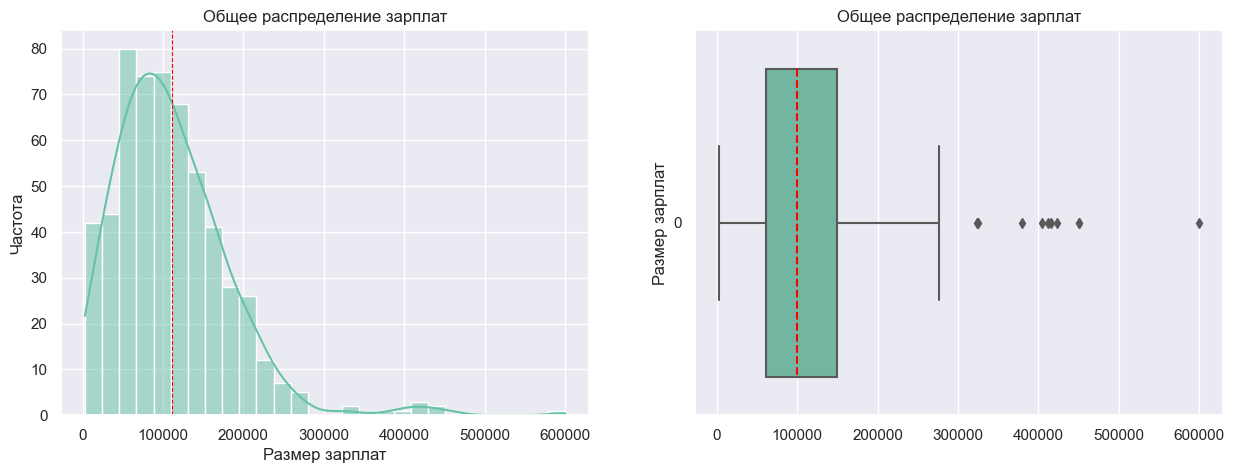

In [655]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплат', ylabel='Частота')
axes[0].set_title('Общее распределение зарплат')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплат')
axes[1].set_title('Общее распределение зарплат')

plt.show()

In [656]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат']
data_agg

,Размер зарплат
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение зарплат близко к нормальному, имеются выбросы.

### Распределение зарптат у специальности Data Scientist

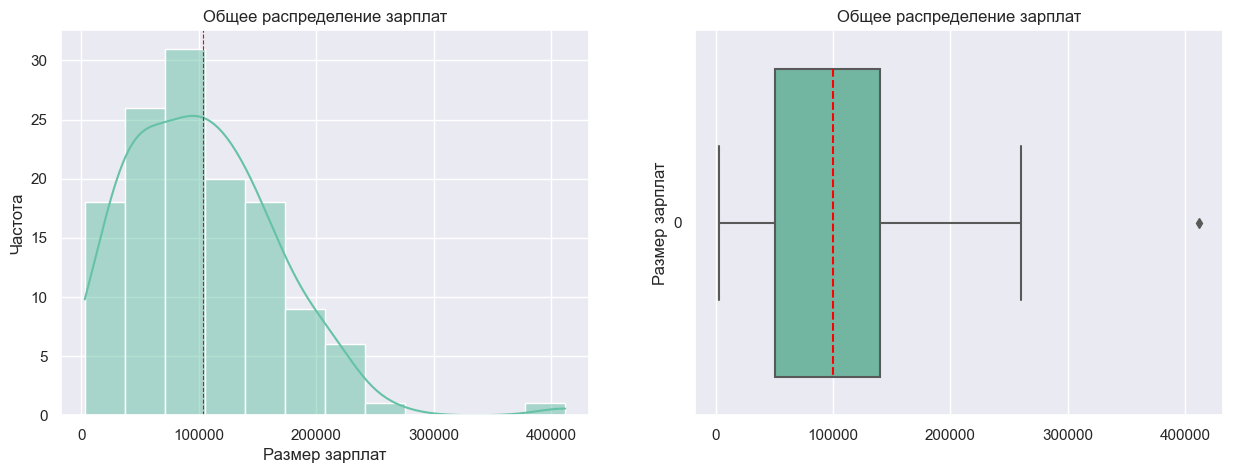

In [657]:
# зыверем из датасета данные о специальности Data Scientist
data_scientist = data[data['job_title'] == 'Data Scientist']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_scientist['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплат', ylabel='Частота')
axes[0].set_title('Общее распределение зарплат')
axes[0].axvline(data_scientist['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_scientist['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплат')
axes[1].set_title('Общее распределение зарплат')

plt.show()

In [658]:
data_agg = data_scientist['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат']
data_agg

,Размер зарплат
count,130.00
mean,103336.35
std,63967.56
min,2859.00
25%,50330.25
50%,100000.00
75%,140400.00
max,412000.00


Распределение зарплат отлично от нормального, имеется один выброс.

### Ежегодный рост зарплат у специалистов Data Scientist

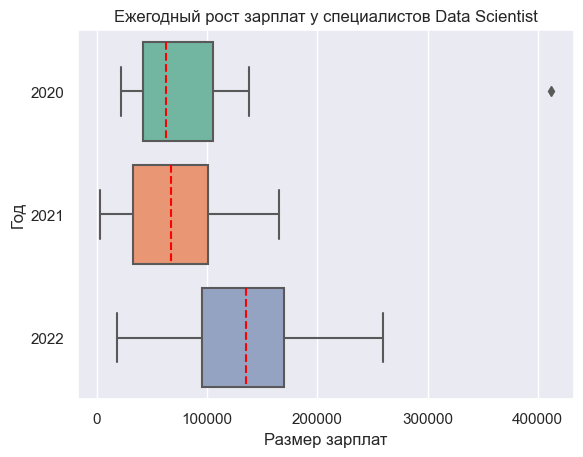

In [659]:
ax = sns.boxplot(data_scientist, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Год')
plt.title('Ежегодный рост зарплат у специалистов Data Scientist')
plt.show()

In [660]:
data_agg = data_scientist.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Ежегодный рост зарплат у специалистов Data Scientist')
data_agg

Ежегодный рост зарплат у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


На первый взгляд распределения зарплат в зависимости от года немного различаются. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

### Соотношение зарплаты Data Scientist и Data Engineer в 2022 году

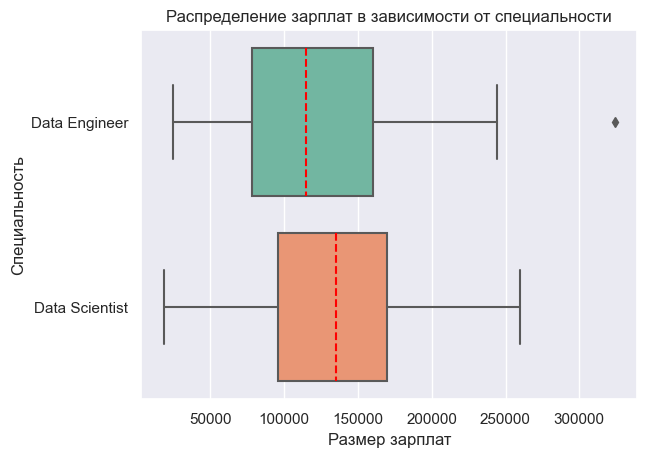

In [661]:
# Выведем данные за 2022 год для специальностей Data Scientist и Data Engineer
data_2022 = data[
    (data['work_year'] == 2022) & 
    ((data['job_title'] == 'Data Scientist') | 
     (data['job_title'] == 'Data Engineer'))
    ]

ax = sns.boxplot(data_2022, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Специальность')
plt.title('Распределение зарплат в зависимости от специальности')
plt.show()

In [662]:
data_agg = data_2022.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Распределение зарплат в зависимости от специальности')
data_agg

Распределение зарплат в зависимости от специальности


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


Распределения зарплат мало различаются в зависимости от специальности. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение зарплат специалистов Data Scientist в компаниях различных размеров

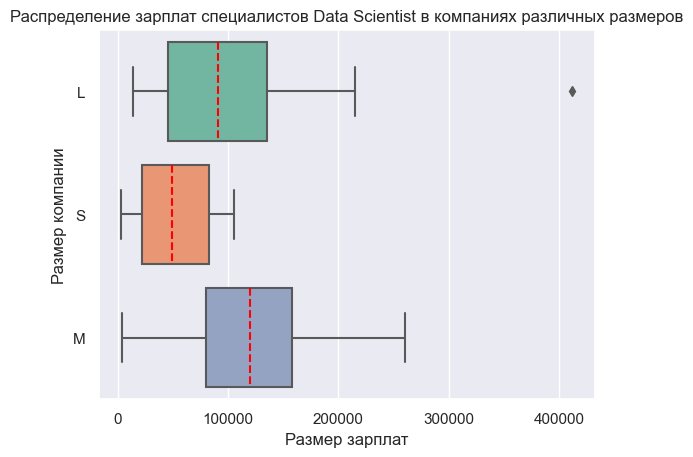

In [663]:
ax = sns.boxplot(data_scientist, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Размер компании')
plt.title('Распределение зарплат специалистов Data Scientist в компаниях различных размеров')
plt.show()

In [664]:
data_agg = data_scientist.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение зарплат специалистов Data Scientist в компаниях различных размеров')
data_agg

Распределение зарплат специалистов Data Scientist в компаниях различных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
M,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Распределения зарплат различны для компаний разных размеров. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

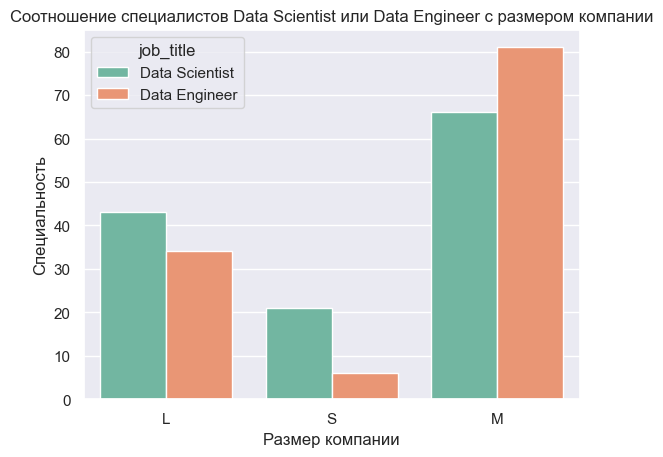

In [665]:
# Выбираем данные о специальностях Data Scientist и Data Engineer
data_jobs = data[
     (data['job_title'] == 'Data Scientist') | 
     (data['job_title'] == 'Data Engineer')
    ]

ax = sns.countplot(data=data_jobs, x=data_jobs['company_size'], hue='job_title')
ax.set(xlabel='Размер компании', ylabel='Специальность')
plt.title('Соотношение специалистов Data Scientist или Data Engineer с размером компании')
plt.show()

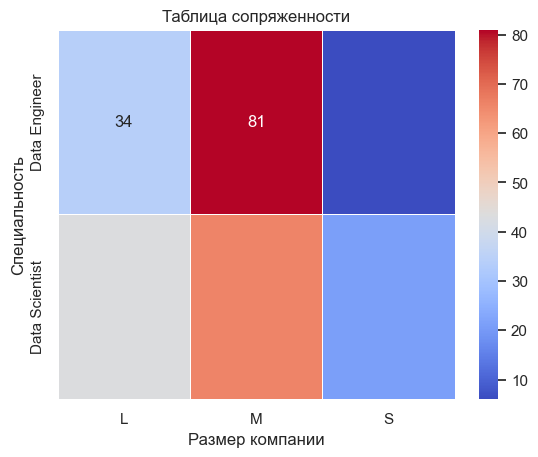

In [666]:
cross_tab = pd.crosstab(index=data_jobs['job_title'], columns=data_jobs['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Специальность')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, в компаниях среднего размера больше всего специалистов  Data Scientist и Data Engineer. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Связь между зарплатами у специалистов Data Engineer и размером компании

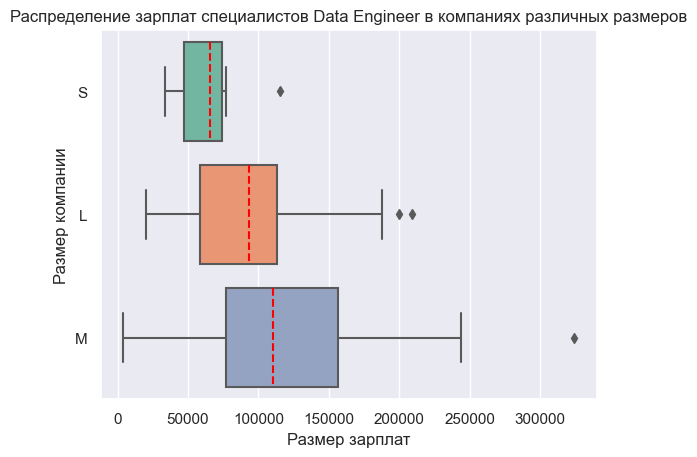

In [667]:
# Выбираем данные о специальностях Data Engineer
data_engineer = data[data['job_title'] == 'Data Engineer']

ax = sns.boxplot(data_engineer, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Размер компании')
plt.title('Распределение зарплат специалистов Data Engineer в компаниях различных размеров')
plt.show()

In [668]:
data_agg = data_engineer.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение зарплат специалистов Data Engineer в компаниях различных размеров')
data_agg

Распределение зарплат специалистов Data Engineer в компаниях различных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,34.0,96875.62,52008.29,20000.0,58653.00,93141.0,112968.00,209100.0
M,81.0,118369.48,60222.08,4000.0,76940.00,110500.0,156600.00,324000.0
S,6.0,66342.50,28862.47,33511.0,47516.75,65511.0,74130.25,115000.0


Распределения зарплат специалистов Data Engineer различны для компаний разных размеров. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение зарплат специалистов Data Scientist в компаниях в зависимости от опыта работы

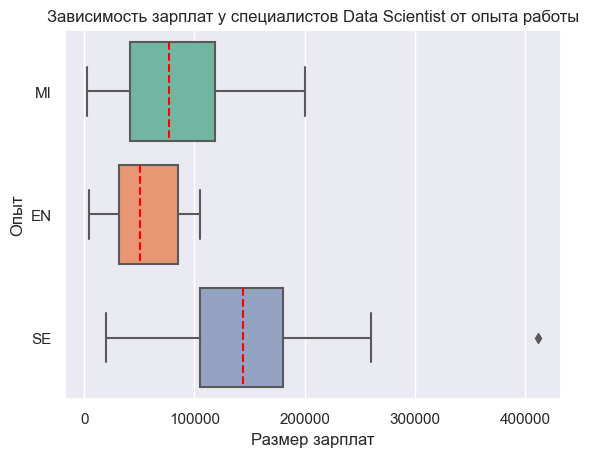

In [669]:
ax = sns.boxplot(data_scientist, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Опыт')
plt.title('Зависимость зарплат у специалистов Data Scientist от опыта работы')
plt.show()

In [670]:
data_agg = data_scientist.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зависимость зарплат у специалистов Data Scientist от опыта работы')
data_agg

Зависимость зарплат у специалистов Data Scientist от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


Распределения зарплат специалистов Data Scientist различны для разного опыта работы. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Вывод по визуализации

По предварительному анализу видно, что есть ряд признаков, который влияет на зарплату. 
К нему относятся:
- размер компании
- год выдачи заработной платы
- специальность
- опыт работы

Чтобы определить, действительно ли эти признаки являются статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных

In [671]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в 2020 году ($μ_1$), 2021 году ($μ_2$) и 2022 году ($μ_3$) не различаются.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в 2020 году ($μ_1$), 2021 году ($μ_2$) и 2022 году ($μ_3$) различаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [672]:
# Смотрим сколько уникальных годов
data['work_year'].unique()

array([2020, 2021, 2022], dtype=int64)

In [673]:
# зарплаты специалистов Data Science в 2020 году
salary_2020 = data[(data['job_title']=='Data Scientist')&(data['work_year']==2020)]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата 2020 года:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

# зарплаты специалистов Data Science в 2021 году
salary_2021 = data[(data['job_title']=='Data Scientist')&(data['work_year']==2021)]['salary_in_usd']
print('---')
print('Зарплата 2021 года:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

# зарплаты специалистов Data Science в 2022 году
salary_2022 = data[(data['job_title']=='Data Scientist')&(data['work_year']==2022)]['salary_in_usd']
print('---')
print('Зарплата 2022 года:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Зарплата 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
---
Зарплата 2021 года:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Зарплата 2022 года:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**


In [674]:
# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [675]:
# Теперь сравним медианы для каждого года
med_1 = salary_2020.median()
med_2 = salary_2021.median()
med_3 = salary_2022.median()

if med_1 < med_2 < med_3:
    print(f'Наблюдается рост зарплат в зависимости от года: {med_1} < {med_2} < {med_3}.')
else:
    print('Не наблюдается рост зарплат в зависимости от года.')

Наблюдается рост зарплат в зависимости от года: 62726.0 < 67233.5 < 135000.0.


**Вывод**

Суде по статистическому тесту зарплаты у специалистов Data Scientist в зависимости от года различаются. И медиана более раннего года меньше следующего.
Значит мы можем утверждать, что наблюдается рост зарплат в зависимости от года.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в 2022 году ($μ_1$) статистически меньше либо равен размеру зарплат у специалистов Data Engineer в 2022 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в 2022 году ($μ_1$) статистически больше размера зарплат у специалистов Data Engineer в 2022 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [676]:
# значения зарплат в 2022 году
salary_DS_2022 = data[
    (data['work_year'] == 2022) & 
    (data['job_title'] == 'Data Scientist')
    ]['salary_in_usd']

salary_DE_2022 = data[
    (data['work_year'] == 2022) & 
    (data['job_title'] == 'Data Engineer')
    ]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для зарплат у специалистов Data Scientist в 2022 году:')
result = stats.shapiro(salary_DS_2022)
decision_normality(result[1])
print('---')
print('Для зарплат у специалистов Data Engineer в 2022 году:')
result = stats.shapiro(salary_DE_2022)
decision_normality(result[1])

Для зарплат у специалистов Data Scientist в 2022 году:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Для зарплат у специалистов Data Engineer в 2022 году:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [677]:
# проводим тест
_, p = stats.mannwhitneyu(salary_DS_2022, salary_DE_2022, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Размер зарплат специалистов Data Scientist статистически меньше либо равен размеру зарплат у специалистов Data Engineer в 2022 году.

## Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в компании размера S ($μ_1$), размера M ($μ_2$) и размера L ($μ_3$) не различаются.

$$ H_1 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в компании размера S ($μ_1$), размера M ($μ_2$) и размера L ($μ_3$) различаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [678]:
# Смотрим сколько уникальных размеров компаний
data['company_size'].unique()

array(['L', 'S', 'M'], dtype=object)

In [679]:
# зарплаты специалистов Data Science в компании размера S
salary_s = data[(data['job_title']=='Data Scientist')&(data['company_size']=='S')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата в компании размера S:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

# зарплаты специалистов Data Science в компании размера M
salary_m = data[(data['job_title']=='Data Scientist')&(data['company_size']=='M')]['salary_in_usd']
print('---')
print('Зарплата в компании размера M:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

# зарплаты специалистов Data Science в компании размера L
salary_l = data[(data['job_title']=='Data Scientist')&(data['company_size']=='L')]['salary_in_usd']
print('---')
print('Зарплата в компании размера L:')
result = stats.shapiro(salary_l)
decision_normality(result[1])

Зарплата в компании размера S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Зарплата в компании размера M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Зарплата в компании размера L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**


In [680]:
# проводим тест
_, p = stats.kruskal(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [681]:
# Теперь сравним медианы для разных размеров компаний
med_1 = salary_s.median()
med_2 = salary_m.median()
med_3 = salary_l.median()

if med_1 < med_2 < med_3:
    print(f'Наблюдается рост зарплат в зависимости от размера компании: {med_1} < {med_2} < {med_3}.')
elif med_1 > med_2 > med_3:
    print(f'Наблюдается снижение зарплат в зависимости от года: {med_1} > {med_2} > {med_3}.')
elif med_1 < med_2 > med_3:
    print(f'Размер зарплат в компаниях среднего размера самый большой: {med_1} < {med_2} > {med_3}.')

Размер зарплат в компаниях среднего размера самый большой: 49268.0 < 119529.5 > 90734.0.


**Вывод**

Суде по статистическому тесту зарплаты у специалистов Data Scientist в зависимости от размера компании различаются. И медиана зарплаты в компании среднего размера больше остальных.
Значит мы можем утверждать, что самые большие зарплаты в компаниях среднего размера.

## Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): между количеством специалистов Data Scientist и Data Engineer в компании размера S, размера M и размера L нет взаимосвязи.

*Альтернативная гипотеза* ($H_1$): между количеством специалистов Data Scientist и Data Engineer в компании размера S, размера M и размера L есть взаимосвязь.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Специальность» (job_title)? — Категориальный.
* Сколько сравниваемых групп? — Три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [682]:
# составляем таблицу сопряжённости
table_data = data[(data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer')]
cross_table = pd.crosstab(table_data['job_title'], table_data['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [683]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

## Есть ли связь между размером зарплат для специальности Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплаты для специалистов Data Engineer в компании размера S ($μ_1$), размера M ($μ_2$) и размера L ($μ_3$) не различаются.

$$ H_1 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): зарплаты для специалистов Data Engineer в компании размера S ($μ_1$), размера M ($μ_2$) и размера L ($μ_3$) различаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [684]:
# зарплаты специалистов Data Engineer в компании размера S
salary_s = data[(data['job_title']=='Data Engineer')
                 &(data['company_size']=='S')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата в компании размера S:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

# зарплаты специалистов Data Engineer в компании размера M
salary_m = data[(data['job_title']=='Data Engineer')
                 &(data['company_size']=='M')]['salary_in_usd']
print('---')
print('Зарплата в компании размера M:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

# зарплаты специалистов Data Engineer в компании размера L
salary_l = data[(data['job_title']=='Data Engineer')
                 &(data['company_size']=='L')]['salary_in_usd']
print('---')
print('Зарплата в компании размера L:')
result = stats.shapiro(salary_l)
decision_normality(result[1])

Зарплата в компании размера S:
p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Зарплата в компании размера M:
p-value = 0.085
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Зарплата в компании размера L:
p-value = 0.109
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать однофакторный дисперсионный анализ (ANOVA).

**Проведём тест**


In [685]:
# проводим тест
_, p = stats.f_oneway(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.032
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [686]:
# Теперь сравним медианы для разных размеров компаний
med_1 = salary_s.median()
med_2 = salary_m.median()
med_3 = salary_l.median()

if med_1 < med_2 < med_3:
    print(f'Наблюдается рост зарплат специалистов Data Engineer в зависимости от размера компании: {med_1} < {med_2} < {med_3}.')
elif med_1 > med_2 > med_3:
    print(f'Наблюдается снижение зарплат специалистов Data Engineer в зависимости от года: {med_1} > {med_2} > {med_3}.')
elif med_1 < med_2 > med_3:
    print(f'Размер зарплат специалистов Data Engineer в компаниях среднего размера самый большой: {med_1} < {med_2} > {med_3}.')

Размер зарплат специалистов Data Engineer в компаниях среднего размера самый большой: 65511.0 < 110500.0 > 93141.0.


**Вывод**

Суде по статистическому тесту зарплаты у специалистов Data Engineer в зависимости от размера компании различаются. И медиана зарплаты в компании среднего размера больше остальных.
Значит мы можем утверждать, что самые большие зарплаты у специалистов Data Engineer в компаниях среднего размера.

## Медианы зарплат специалистов Data Scientist равны 100000 руб.?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): медианы зарплат у специалистов Data Scientist ($μ_1$) равны 100000 руб.

$$ H_1 : μ_1 = 100000 $$

*Альтернативная гипотеза* ($H_1$): медианы зарплат у специалистов Data Scientist ($μ_1$) не равны 100000 руб.

$$ H_1 : μ_1 \neq 100000 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [687]:
# зарплаты специалистов Data Scientist
salary_DS = data[(data['job_title']=='Data Scientist')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата:')
result = stats.shapiro(salary_DS)
decision_normality(result[1])

Зарплата:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий знаков.

**Проведём тест**


In [688]:
# проводим тест
from statsmodels.stats.descriptivestats import sign_test
_, p = sign_test(salary_DS, 100000)
decision_hypothesis(p)

p-value = 0.858
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Суде по статистическому тесту медианы зарплат у специалистов Data Scientist равны 100000 руб.

## Есть ли связь между зарплатой специалистов Data Scientist и опытом работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплаты для специалистов Data Scientist уровня Entry-level/Junior ($μ_1$), уровня Mid-level/Intermediate ($μ_2$), уровня Senior-level/Expert ($μ_3$) не различаются.

$$ H_1 : μ_1 = μ_2 = μ_3 $$ 

*Альтернативная гипотеза* ($H_1$): зарплаты для специалистов Data Scientist уровня Entry-level/Junior ($μ_1$), уровня Mid-level/Intermediate ($μ_2$), уровня Senior-level/Expert ($μ_3$) различаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [689]:
# Смотрим сколько уникальных уровней по опыту работы для специалистов Data Scientist
data_scientist['experience_level'].unique()

array(['MI', 'EN', 'SE'], dtype=object)

In [690]:
# зарплаты специалистов Data Scientist уровня Entry-level/Junior
salary_mi = data[(data['job_title']=='Data Scientist')
                 &(data['experience_level']=='MI')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата уровня Entry-level/Junior:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

# зарплаты специалистов Data Scientist уровня Mid-level/Intermediate
salary_se = data[(data['job_title']=='Data Scientist')
                 &(data['experience_level']=='SE')]['salary_in_usd']
print('---')
print('Зарплата уровня Mid-level/Intermediate:')
result = stats.shapiro(salary_se)
decision_normality(result[1])

# зарплаты специалистов Data Scientist уровня Senior-level/Expert
salary_en = data[(data['job_title']=='Data Scientist')
                 &(data['experience_level']=='EN')]['salary_in_usd']
print('---')
print('Зарплата уровня Senior-level/Expert:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

Зарплата уровня Entry-level/Junior:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
---
Зарплата уровня Mid-level/Intermediate:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
---
Зарплата уровня Senior-level/Expert:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплаты»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**


In [691]:
# проводим тест
_, p = stats.kruskal(salary_mi, salary_se, salary_en)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Суде по статистическому тесту зарплаты у специалистов Data Scientist в зависимости от опыта работы различаются.

## Итоговые результаты исследования

*   Наблюдается рост зарплат в зависимости от года.
*   Размер зарплат специалистов Data Scientist меньше либо равен размеру зарплат у специалистов Data Engineer в 2022 году.
*   Зарплаты у специалистов Data Scientist в зависимости от размера компании различаются. Самые большие зарплаты в компаниях среднего размера.
*   Существует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.
*   Зарплаты у специалистов Data Engineer в зависимости от размера компании различаются. Самые большие зарплаты в компаниях среднего размера.
*   Медианы зарплат у специалистов Data Scientist равны 100000 руб.
*   Зарплаты у специалистов Data Scientist в зависимости от опыта работы различаются.